# Transfer Learning - SqueezeNet

Unicamp - 2018

Nesta tarefa foi carregada a SqueezeNet com pesos treinados no ImageNet e feita a transferênicia de aprendizado para um problema de classificação de raças de cachorro. 


As tarefas são:

**1) Definição do modelo [0.25 pts]**
- Instancie o modelo base da SqueezeNet;
- Escolha qual camada da rede que você utilizará como ponto de partida (..., fire8, fire9, drop9);
- Escolha quais camadas terão os pesos atualizados e quais serão congeladas;
- Adicione as camadas adicionais no topo da rede. Vocês estão livres em relação à quantidade e tipo de camadas após a SqueezeNet.

**2) Treinamento [0.25 pts]**
- Compile o seu modelo, definindo qual a loss e otimizador que serão utilizados;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que você conseguirem;

**3) Teste [0.25 pts]**
- Avalie o conjunto de teste e reporte a loss e a acurácia normalizada;

**4) Conclusões [0.25 pts]**
- Escreva um parágrafo resumindo o que você fez, as dificuldades que encontrou, o que deu certo/errado e as suas conclusões desta atividade.

------

## Imports

In [1]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.utils import np_utils
from keras.preprocessing.image import load_img, img_to_array

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Definição do modelo base da SqueezeNet
As funções abaixo criam o modelo da SqueezeNet e carregam os seus pesos treinados no ImageNet.

In [2]:
# Fire Module Definition
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

#SqueezeNet model definition
def SqueezeNet(input_shape):
    img_input = Input(shape=input_shape) #placeholder
    
    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(1000, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')

    # Download and load ImageNet weights
    model.load_weights('./squeezenet_weights_tf_dim_ordering_tf_kernels.h5')
    
    return model    

# Dataset
O dataset é composto por 83 classes (raças de cachorro) com 100 imagens de treinamento por classe. No conjunto de validação, há 73 imagens por classe. As imagens estão nomeadas no formato `xx_yyyy.jpg`, onde `xx` denota a classe (de 00 até 82) e `yyyy` é apenas um identificador da imagem.

** IMPORTANTE NÃO ALTERAR O NOME/LOCAL DAS IMAGENS** 

In [3]:
datasetDir = "./INF0618_Tarefa03_dogDataset"
nbClasses = 83

def getDatasetSize(split='train'):
    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
    splitDir = os.path.join(datasetDir, split)
    
    #Get all file names for that split
    fileNames = [img for img in os.listdir(splitDir) if img[-3:] in ['jpg', 'png', 'jpeg']]
    return len(fileNames)

#Read our dataset in batches
def loadDatasetInBatches(split="train", batch_size=32):
    if split not in ["train", "val", "test"]:
        raise ValueError(split + " not recognized. Did you mean 'train', 'val' or 'test'?")
    splitDir = os.path.join(datasetDir, split)
    
    #Get all file names for that split
    fileNames = [img for img in os.listdir(splitDir) if img[-3:] in ['jpg', 'png', 'jpeg']]

    while True:
        shuffledFileNames = sample(fileNames, len(fileNames)) #shuffle images in each epoch
        imagePaths = [os.path.join(splitDir,img) for img in shuffledFileNames] #get image paths
        
        batch, labelList = [], []
        nInBatch = 0
        
        #loop of one epoch
        for idx in list(range(len(imagePaths))):
                        img = img_to_array(load_img(imagePaths[idx], target_size=(112,112)))
                        img = img.astype('float32')
                        img /= 255.0
                    
                        label = np_utils.to_categorical(getLabelFromImgName(shuffledFileNames[idx], split), nbClasses)
                        
                        batch.append(img)
                        labelList.append(label)
                        nInBatch += 1
                        
                        #if we already have one batch, yields it
                        if nInBatch >= batch_size:
                            yield np.array(batch), np.array(labelList)
                            batch, labelList = [], []
                            nInBatch = 0

        #yield the remaining of the batch
        if nInBatch > 0:
            yield np.array(batch), np.array(labelList)


def getLabelFromImgName(imgName, split):
    return int(imgName.split("_")[0])
        
    
#plot the images from imgList
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
               
def plotImage(img):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img*255.0), interpolation='nearest')
    plt.show()
    
trainSetSize = getDatasetSize("train")
valSetSize = getDatasetSize("val")
testSetSize = getDatasetSize("test")

print("# images in Train set: ", trainSetSize)
print("# images in Val set: ", valSetSize)
print("# images in Test set: ", testSetSize)

# images in Train set:  8300
# images in Val set:  6022
# images in Test set:  5420


(5, 112, 112, 3) (5, 83)


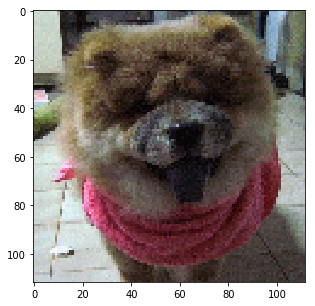

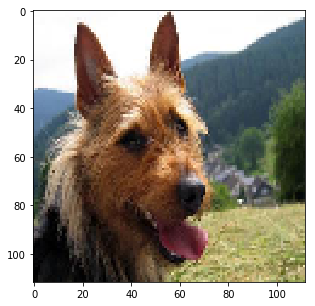

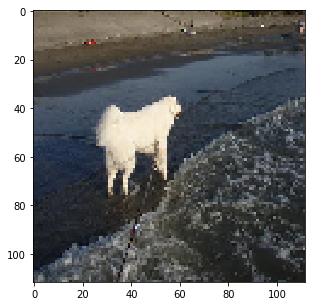

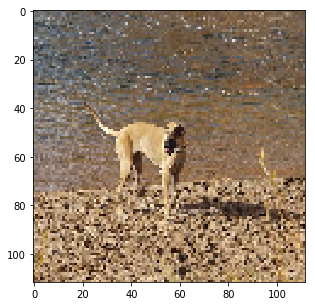

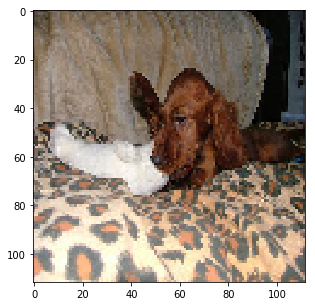

In [4]:
for batch, labels in loadDatasetInBatches(split='train', batch_size=5):
    print(batch.shape, labels.shape)
    plotImages(batch)
    break

### Como o load do dados é feito...  
O método que iremos utilizar para ler os dados é o `loadDatasetInBatches(split='train', batch_size=32)`. Ele é um generator (semelhante ao método que fazia a aumentação de dados na Aula 03), ou seja, ele gera um fluxo de batches e labels a partir do nosso dataset.

**Argumentos**:
- (string) **split**: pode ser `'train'`, `'val'` ou `'test'`. Se refere a qual conjunto de dados que iremos ler (treino, validação ou teste);
- (int) **batch_size**: quantas imagens por batch;

**Retorno**: 
- **batch**: retorna um array do numpy com as imagens carregadas e pre-processadas. **batch** tem dimensões (batch_size, 227, 227, 3), pois as imagens tem tamanho 227x227 e tem 3 canais (RGB);
- **labels**: retorna um array do numpy com as labels já transformadas em one_hot_encode (array de 83 dimensões, com 1 na posição do índice da classe e 0 nas outras posições). **batch** tem dimensões (batch_size, 83);
    
Utilizando o argumento `split`, o método lê os nomes das imagens do diretório correto e as embaralha (para garantir que a cada época os batches sejam diferentes). Para cada época (um loop do `for` interno), o método irá carregar uma imagem por vez e irá gerar a sua label (obtendo a classe pelo próprio nome da imagem). Esta imagem/label será colocada em listas **batch/labelList**.

Quando estas listas estiverem com **batch_size** elementos, teremos gerado um batch. O método dá um yield nessas duas e recomeça a construção de um novo batch. Quando o `for` terminar, iremos ter completado uma época. O `while True` apenas garante uma nova época seja iniciada. Quem controlará o fim do `while` vai ser o método que fará o fit, portanto não precisamos nos preocupar com isso.  

-----------
-----------
-----------
** -----> A tarefa começa aqui !!! Vocês não precisam modificar nada dos códigos acima!** 

# Definição do modelo [0.25 pts]

- Instancie o modelo base da SqueezeNet;
- Escolha qual camada da rede que você utilizará como ponto de partida (..., fire8, fire9, drop9);
- Escolha quais camadas terão os pesos atualizados e quais serão congeladas;
- Adicione as camadas adicionais no topo da rede. Vocês estão livres em relação à quantidade e tipo de camadas após a SqueezeNet.
    - Lembrem-se que ao final da rede, precisamos de camadas de classificação:
        - Conv2D + GlobalAveragePooling + SoftMax (aula 05)
        - Flatten + Dense + SoftMax (aulas anteriores)
    - Se acharem necessário, podem também adicionar outras camadas (Dropout, Conv2D, módulos Fire);
    
    
**Não se esqueçam de:**
- Definir novas camadas da mesma forma que fizemos na Aula 05 (utilizando o x = ...(x))
- Ao final da célula, definir o modelo novo com o input da squeeze base e o output da última camada adicionada

In [5]:
# Definir o modelo base da squeezeNet 
squeezeNetModel = SqueezeNet((112,112,3))

# Escolher a camada que será o ponto de partida 

print([layer.name for layer in squeezeNetModel.layers])
print("\n\nFreeze layers up until: ", squeezeNetModel.layers[-20].name)

#freeze layers
for layer in squeezeNetModel.layers[:-20]:
    layer.trainable = False

    
#Add new classification layers
x = squeezeNetModel.get_layer(name="drop9").output

# Congelar (ou não) camadas
for layer in squeezeNetModel.layers[:-20]:
    layer.trainable = False


# Adicionar novas camadas
# camadas criadas para resolver o problema específico
x = Convolution2D(nbClasses, (1, 1),
                  padding='same',
                  kernel_initializer='glorot_uniform')(x)

x = Activation('relu')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.25)(x)
x = Activation('softmax')(x)

#new Model
# Não se esqueça de definir o nome modelo, onde baseSqueezeNetModel 
# é o modelo base da Squeeze que vc definiu ali em cima
model = Model(squeezeNetModel.inputs, x, name='squeezenet_new')

['input_1', 'conv1', 'relu_conv1', 'pool1', 'fire2/squeeze1x1', 'fire2/relu_squeeze1x1', 'fire2/expand1x1', 'fire2/expand3x3', 'fire2/relu_expand1x1', 'fire2/relu_expand3x3', 'fire2/concat', 'fire3/squeeze1x1', 'fire3/relu_squeeze1x1', 'fire3/expand1x1', 'fire3/expand3x3', 'fire3/relu_expand1x1', 'fire3/relu_expand3x3', 'fire3/concat', 'pool3', 'fire4/squeeze1x1', 'fire4/relu_squeeze1x1', 'fire4/expand1x1', 'fire4/expand3x3', 'fire4/relu_expand1x1', 'fire4/relu_expand3x3', 'fire4/concat', 'fire5/squeeze1x1', 'fire5/relu_squeeze1x1', 'fire5/expand1x1', 'fire5/expand3x3', 'fire5/relu_expand1x1', 'fire5/relu_expand3x3', 'fire5/concat', 'pool5', 'fire6/squeeze1x1', 'fire6/relu_squeeze1x1', 'fire6/expand1x1', 'fire6/expand3x3', 'fire6/relu_expand1x1', 'fire6/relu_expand3x3', 'fire6/concat', 'fire7/squeeze1x1', 'fire7/relu_squeeze1x1', 'fire7/expand1x1', 'fire7/expand3x3', 'fire7/relu_expand1x1', 'fire7/relu_expand3x3', 'fire7/concat', 'fire8/squeeze1x1', 'fire8/relu_squeeze1x1', 'fire8/expa

# Treinamento [0.25 pts]

- Compile o seu modelo, definindo qual a loss e otimizador que serão utilizados;
- Defina também número de batches e número de épocas;
- Treine para obter a maior acurácia que você conseguirem;


No treinamento iremos utilizar o `fit_generator` (mesmo utilizado no Aula03 com Data Augmentation). Ele recebe um generator (que será fornecido pelo `loadDatasetInBatches`). Como o generator retorna um fluxo de batches/labels, o `fit_generator` não tem informação sobre o tamanho dataset. Por isso, precisamos informar o número de épocas (parâmetro `epochs`) e também quantos batches compõe uma época (parâmetro `steps_per_epoch`). Ao total, teremos 2 generators, um para o conjunto de treino e outro para o conjunto de teste.

Para mais informações sobre o fit_generator e seus parâmetros, [acesse a documentação do Keras](https://keras.io/models/sequential/#fit_generator).

In [6]:
#Compile o modelo
from keras import optimizers
adam_opt = optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

In [7]:
#Definir tamanho do batch e número de épocas
batch_size = 12
epochs = 8

#Criação dos generators
trainGenerator = loadDatasetInBatches(split='train', batch_size = batch_size)
valGenerator = loadDatasetInBatches(split='val', batch_size = batch_size)

#Fit nos dados
model.fit_generator(trainGenerator, 
                    steps_per_epoch= int(trainSetSize / batch_size), 
                    epochs = epochs,
                    validation_data = valGenerator,  
                    validation_steps = int(valSetSize / batch_size))

Epoch 1/8
691/691 [==============================] - 357s 516ms/step - loss: 4.5019 - acc: 0.0142 - val_loss: 4.4149 - val_acc: 0.0213
Epoch 2/8
691/691 [==============================] - 276s 399ms/step - loss: 4.4133 - acc: 0.0172 - val_loss: 4.4031 - val_acc: 0.0233
Epoch 3/8
691/691 [==============================] - 274s 397ms/step - loss: 4.3924 - acc: 0.0281 - val_loss: 4.3490 - val_acc: 0.0413
Epoch 4/8
691/691 [==============================] - 276s 400ms/step - loss: 4.3421 - acc: 0.0381 - val_loss: 4.2610 - val_acc: 0.0664
Epoch 5/8
691/691 [==============================] - 273s 395ms/step - loss: 4.2542 - acc: 0.0601 - val_loss: 4.1765 - val_acc: 0.0812
Epoch 6/8
691/691 [==============================] - 276s 400ms/step - loss: 4.1575 - acc: 0.0801 - val_loss: 4.0337 - val_acc: 0.1037
Epoch 7/8
691/691 [==============================] - 276s 400ms/step - loss: 4.0355 - acc: 0.1006 - val_loss: 3.9392 - val_acc: 0.1225
Epoch 8/8
691/691 [==============================] - 27

# Teste [0.25 pts]
O teste será feito da mesma forma, utilizando `loadDatasetInBatches` para o conjunto de teste. 

In [8]:
#Criação do generator p/ o conjunto de teste
testGenerator = loadDatasetInBatches(split='test', batch_size=batch_size)

#Teste
metrics = model.evaluate_generator(testGenerator, 
                                   steps=int(testSetSize/batch_size), 
                                   verbose=1)

print("Test Loss ---> ", metrics[0])
print("Test Accuracy ---> ", metrics[1])    #Test is balanced, so Acc is normalized

451/451 [==============================] - 189s 419ms/step
Test Loss --->  3.75129101757464
Test Accuracy --->  0.14393939664318928


# Conclusões  [0.25 pts]
Escrevam um parágrafo com as conclusões que vocês tiraram na tarefa. Comentem as dificuldades encontradas, as tentativas feitas, como foi o seu treinamento, apontando a motivação pelas decisões tomadas. Se o resultado ficou melhor/pior do que o que você esperava, o que você acha que pode ter acontecido?

Para essa tarefa, foi utilizada a SqueezeNet com pesos treinados no ImageNet e transfer learning para um problema de
classificação de raças de cachorro.

Em primeiro lugar, é importante mencionar que alguns parâmetros foram alterados.
Por problemas de memória, as imagens foram convertidas para 112, 122, 3 e o batch escolhido foi de 12, pois muito mais do que isso estava gerando memory error e o notebook estava travando!!!

Também, por limites de poder computacional e tempo, foi optado utilizar somente 8 épocas.
Foi testado rodar com mais épocas (20) e foi constatado que a acurácia aumentava consideravelmente.
Contudo, o notebook travou em 13 épocas e precisei recomeçar!!!
Depois travou em 9 épocas e precisei compilar novamente!!!
Por isso decidi adotar 8 épocas para o treinamento, mesmo sabendo que é longe do ideal.



Foi instanciado o modelo base da SqueezeNet conforme realizado em aula.
Foram congeladas as camadas até fire7/concat (ou seja, foram descongeladas as camadas drop9, fire9 e fire8).
Foi utilizada como ponto de partida a camada drop9.

Obs: Antes eu havia congelado todas as camadas, mas, conforme a tarefa de TransferLearning mostrou, o resultado obtido foi
muito ruim; somente um pouco melhor do de um chute mesmo com treinando por algumas épocas.

Eu também testei fazer o fine tuning de mais camadas mas, por restrição de poder computacional, o treinamento estava
demorando mais do que o tolerável. Desse modo, decidi fazer o ajuste somente nas camadas drop9, fire9 e fire8.

Foram conectadas à camada drop9 da SqueezeNet 3 novas camadas:

- Uma convolucional 2d que tem como entrada o número de classes do problema (83), inicialização glorot_uniform e ativação relu.
- Uma camada de global average pooling 2d.
- Ativação softmax.

Também foi utilizado dropout com probabilidade de 25% para reduzir a chance de overfitting.
A learning rate escolhida é menor do que a de costume para, tendo como objetivo prevenir overshooting (dica do monitor).


Os resultados obtidos foram:

Train Loss (após 8 épocas): 3.9760

Train Accuracy (após 8 épocas): 0.1163

Val Loss (após 8 épocas): 3.8484

Val Accuracy (após 8 épocas): 0.1293

Test Loss:  3.75129101757464

Test Accuracy: 0.14393939664318928
    
    
As acurácias tanto para treino, teste e validação estão boas (considerando que são 83 classes de cachorro no problema), mas muito abaixo do esperado.
Isso ocorreu pois o modelo não foi treinado pelo número de épocas desejado (pelo menos 30) devido
a falta de recursos computacionais e tempo disponíveis. Acredito que com essa mesma rede e mais de 30 épocas,
seria possível ultrapassar 50% de acurácia no conjunto de testes.

Eu verifiquei empiricamente que a acurácia demora muitas épocas para conseguir aumentar.
Ou seja, a rede precisa passar algumas vezes por todo o conjunto de dados para conseguir ter um resultado bom na acurácia.
Ainda no fim da primeira época, a acurácia não fica muito maior que o equivalente a um "chute" (pouco maior que 1%).

Como dificuldade grande dificuldade inicial (comentada com o monitor da disciplina), eu demorei muitas horas para conseguir
sincronizar as pastas física do windows e virtual do docker com o conteúdo desejado, de modo que demorei muito tempo para
conseguir enviar as imagens para o diretório correto e iniciar a análise.

Também tive uma grande dificuldade envolvendo poder e tempo de processamento, pois a capacidade de processamento do meu laptop
pessoal é muito abaixo do esperado. Eu tentei realizar a atividade em ambiente virtual (cloud), mas tive dificuldades com
a instalação das ferramentas necessárias para o desenvolvimento.


Quanto às decisões tomadas, acredito que tomei uma boa decisão considerando o tempo de execução que eu tinha disponível. A ideia é que fazenendo o fine tuning de mais camadas (ou seja, descongelando-as), o resultado do modelo seja melhor. Mas isso vem a um custo enorme que é o de poder computacional e tempo de processamento.

Também vale lembrar que não foram utilizadas mais épocas por limitante de tempo de processamento. Caso mais épocas fossem utilizadas, a acurácia seria relativamente maior (como constatado antes do notebook reiniciar por problema de memória).

Por fim, vale lembrar que, por limite de memória (memory error), foram utilizadas imagens de resolução menor que,
em teoria, prejudicam um pouco a performance do modelo implementado na atividade.

O resultado ficou tão bom quanto o esperado, dados os limitantes de memória, tempo e poder computacional disponíveis no momento.
Caso houvessem mais recursos, seria interessante descongelar mais camadas e rodar o modelo por mais épocas para avaliar
o resultado obtido nessas condições.